Автор: Лейман М.А.   
Дата создания: 12.06.2025  


# 1. Обработка датасета UAVOD10 

### Классы датасета   
'building': 0,      		здание  
'cable-tower': 1, 		кабельная вышка  
'cultivation-mesh-cage': 2,  	сетка для выращивания  
'landslide': 3, 		оползень  
'pool': 4, 			бассейн  
'prefabricated-house': 5, 	сборный-дом"  
'quarry': 6,			карьер  
'ship': 7, 			корабль  
'vehicle': 8,			транспортное средство  
'well': 9			колодец  

## Преобразование датасета в формат YOLO

In [1]:
from glob import glob
import os, random, glob, shutil, math
import cv2
import numpy as np
from typing import List, Tuple


import preprocess
import importlib
importlib.reload(preprocess)  # Обновляет при каждом запуске

from preprocess import convert_voc_to_yolo, count_objects_by_class, cleaned1, find_images_with_class, splitting_dataset, mix_img, generate_crops_for_dataset, convert_to_yolo, convert_gpg1

In [2]:
# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

target_original = 'dataset_UAVOD/datasets_original/target/'    # таргеты XML
xml_dir = os.path.join(path_dataset, target_original)  

image_original = 'dataset_UAVOD/datasets_original/image/'    # Исходные изображения
image_dir = os.path.join(path_dataset, image_original)  

target_yolo_original = 'dataset_UAVOD/datasets_original/target_yolo/'    # YOLO разметка
output_txt_dir = os.path.join(path_dataset, target_yolo_original) 

print("Текущая папка:", current_directory)  
print("Датасет:      ", path_dataset)  
print("Таргет:       ", xml_dir)  
print("Изображения:  ", image_dir)  
print("Таргет YOLO:  ", output_txt_dir)  


Текущая папка: /home/maksim/develops/python/Zala_task/Zala_task
Датасет:       /home/maksim/develops/python/Zala_task/Zala_task/dataset
Таргет:        /home/maksim/develops/python/Zala_task/Zala_task/dataset/dataset_UAVOD/datasets_original/target/
Изображения:   /home/maksim/develops/python/Zala_task/Zala_task/dataset/dataset_UAVOD/datasets_original/image/
Таргет YOLO:   /home/maksim/develops/python/Zala_task/Zala_task/dataset/dataset_UAVOD/datasets_original/target_yolo/


In [3]:
def convert_annotation(output_txt_dir):
    # Названия классов
    class_names = ["building", "cultivation-mesh-cage", "landslide",
               "pool", "prefabricated-house", "quarry", "ship", "vehicle", "well"]
    # Обрабатываем все XML
    for xml_file in os.listdir(xml_dir):
        os.makedirs(output_txt_dir, exist_ok=True)
        if xml_file.endswith(".xml"):
            convert_voc_to_yolo(os.path.join(xml_dir, xml_file), output_txt_dir, class_names)

    print("Конвертация завершена!")

# convert_annotation(output_txt_dir)  

### Количество объектов по классам

In [4]:

path = output_txt_dir
count_objects_by_class(path)

Количество объектов по классам:
Класс 0: 12662 объектов
Класс 2: 263 объектов
Класс 3: 40 объектов
Класс 4: 49 объектов
Класс 5: 2027 объектов
Класс 6: 83 объектов
Класс 7: 771 объектов
Класс 8: 466 объектов
Класс 9: 677 объектов


###  Работа с классами  
объединение классов,  удаление лишних классов, переименование классов   

In [5]:
# ===============    Словарь  классов для переименования
class_map = {
    533: 0,
}

# =======================     Классы, которые удаляем 
remove_classes = {3, 4, 6}
input_dir = "dataset_full_3/labels/train/"

# cleaned1(class_map, remove_classes, input_dir, path_dataset)

In [6]:
input_dir = "dataset_UAVOD/dataset_orign_2/target/"
path = os.path.join(path_dataset, input_dir)
count_objects_by_class(path)

Количество объектов по классам:
Класс 0: 15570 объектов
Класс 2: 272 объектов
Класс 3: 1 объектов
Класс 4: 745 объектов
Класс 6: 567 объектов
Класс 7: 805 объектов


In [7]:
#  поиск изображений с определёнными классами

label_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_orign_2/target/"
target_class = 3
files = find_images_with_class(label_dir, target_class)

print(f"Найдено {len(files)} изображений с классом {target_class}:")
for f in files:
    print(f)

Найдено 1 изображений с классом 3:
278.jpg


### разделение датасета

In [8]:
output_base_dir = "dataset/dataset_UAVOD/datasets_split"
image_original = 'dataset_UAVOD/dataset_orign_2/image/'    # Исходные изображения
images_path = os.path.join(path_dataset, image_original)  

target_yolo_original = 'dataset_UAVOD/dataset_orign_2/target/'   
labels_path = os.path.join(path_dataset, target_yolo_original) 

# splitting_dataset(image_dir=images_path, label_dir=labels_path, output_base_dir=output_base_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)


#### Баланс классов 

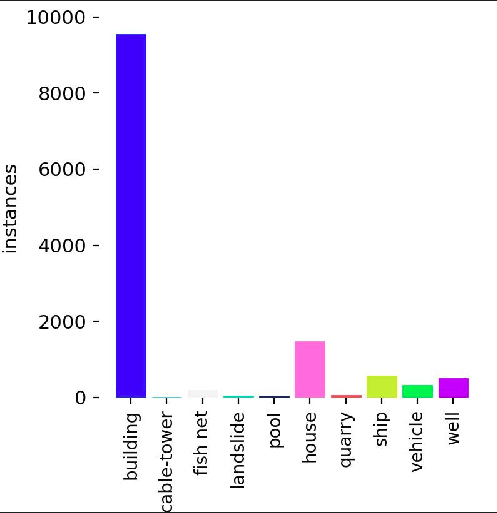

## Преобразование датасета 

Из исходных изображений (больших)  вырезаются квадратные изображения с шагом  и объединяются с исходным датасетом. 


In [9]:
def mix():
    # ПАРАМЕТРЫ 
    SRC_IMG_DIR   = "/home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/image/test/"        
    SRC_LBL_DIR   = "/home/maksim/develops/python/devsTraining/zala_task/dataset/UNION_dataset/target/test/"
    OUT_IMG_DIR   = "dataset/custom_dataset/mix_out/images"        
    OUT_LBL_DIR   = "dataset/custom_dataset/mix_out/labels"

    IMG_SIZE      = 1024                    # итоговый квадрат
    CTX_MARGIN    = 8                       # паддинг вокруг bbox (px)
    N_MIN, N_MAX  = 20, 100                 # требуемый диапазон объектов
    OVERLAP_IOU   = 0.05                    # макс. IoU между вставками
    SKIP_CLASSES  = {0, 2, 3, 4}            # какие классы НЕ переносим
    patch_margin = 16                       # отступ от других объектов в пикселях
    # SKIP_CLASSES  = {0} 

    # random.seed(42)

    mix_img(SRC_IMG_DIR, SRC_LBL_DIR, OUT_IMG_DIR, OUT_LBL_DIR, img_size=IMG_SIZE, margin=CTX_MARGIN, n_min=N_MIN, n_max=N_MAX, over_iou=OVERLAP_IOU, skip_classes=SKIP_CLASSES, patch_margin=patch_margin)

# mix()

In [10]:
def aug_1():
    # Получаем текущую рабочую папку  
    current_directory = os.getcwd()  

    path_dataset = os.path.join(current_directory, "dataset")

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'dataset_UAVOD/set/image/train/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/set/target/train/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 1:
        image_1 = 'dataset_UAVOD/set/image/test/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/set/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'dataset_UAVOD/set/image/test/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/set/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)        

        


    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1300,         # Размер вырезки
        step=150,                # Шаг для сдвигов окна
        exclude_classes=[0, 2, 3, 4,]  # Исключенные классы
    )

# aug_1()

#### Баланс классов после обработки датасета  

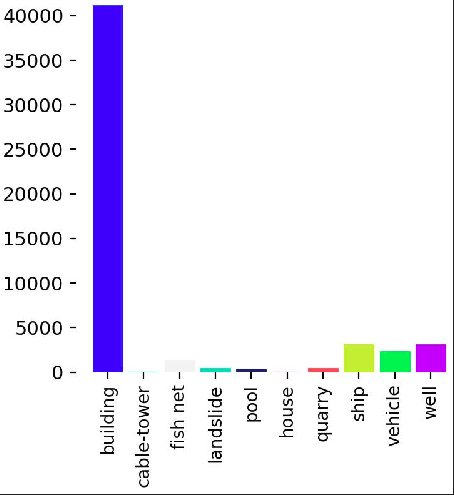

## 2. Датасет VEDAI  

https://paperswithcode.com/dataset/vedai  

In [ ]:
def aug_2():

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'dataset_VEDAI/set/image_1/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_VEDAI/set/target_1/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full_1/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 1:
        image_1 = 'dataset_UAVOD/datasets_split/images/test/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'dataset_UAVOD/datasets_split/images/val/'    
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_UAVOD/datasets_split/labels/val/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 
        
        image_2 = 'dataset_full/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)   



    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1024,         # Размер вырезки
        step=200,                # Шаг для сдвигов окна
        exclude_classes=[0]  # Исключенные классы
    )

# aug_2()

In [19]:
input_dir = "dataset_VEDAI/set/target/train/"
path = os.path.join(path_dataset, input_dir)
count_objects_by_class(path)

Количество объектов по классам:
Класс 0: 3179 объектов
Класс 1: 47 объектов
Класс 3: 5 объектов
Класс 4: 253 объектов
Класс 5: 1 объектов
Класс 6: 2083 объектов
Класс 7: 123 объектов


#### Баланс классов после добавления датасета VEDAI  

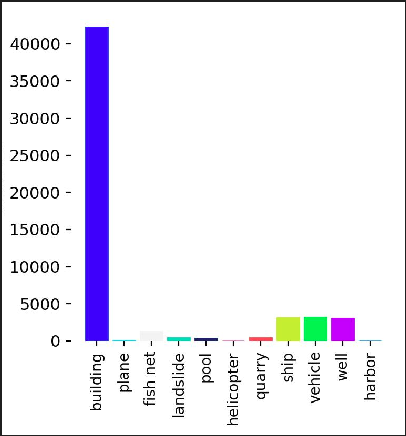

## 3. ДАТАСЕТ DOTA  

In [11]:
import os
import xml.etree.ElementTree as ET
import glob

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset")

 
labels_1 = 'dataset_DOTA/original/lables/'  
dota_labels_path = os.path.join(path_dataset, labels_1) 

label_paths = glob.glob(f"{dota_labels_path}*.txt")       # путь к аннотациям DOTA
class_names = set()

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) > 8:                               # Проверяем, есть ли название класса (оно 9-й элемент)
            class_name = parts[-2]                       # В DOTA имя класса идет перед difficulty
            class_names.add(class_name)

print("Классы датасета:")
print("Найденные классы в DOTA:", class_names)

Классы датасета:
Найденные классы в DOTA: {'storage-tank', 'helicopter', 'ground-track-field', 'harbor', 'soccer-ball-field', 'baseball-diamond', 'bridge', 'tennis-court', 'small-vehicle', 'plane', 'basketball-court', 'large-vehicle', 'ship', 'roundabout', 'swimming-pool', 'container-crane'}


In [12]:
image_2 = 'dataset_DOTA/dataset_DOTA/images/'   
images_path = os.path.join(path_dataset, image_2)  
labels_2 = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
yolo_labels_path = os.path.join(path_dataset, labels_2)  


os.makedirs(yolo_labels_path, exist_ok=True)

# Словарь классов DOTA  в YOLO 
dota_classes = {
    "plane": 0, "ship": 1, "storage-tank": 2, "baseball-diamond": 3, "tennis-court": 4,
    "basketball-court": 5, "ground-track-field": 6, "harbor": 7, "bridge": 8,
    "large-vehicle": 9, "small-vehicle": 10, "helicopter": 11, "roundabout": 12,
    "soccer-ball-field": 13, "swimming-pool": 14, "container-crane": 15
}


# convert_to_yolo(dota_classes, images_path, dota_labels_path, yolo_labels_path)

In [13]:
input_dir = "dataset_DOTA/original/yolo_labels/"
path = os.path.join(path_dataset, input_dir)
count_objects_by_class(path)

Количество объектов по классам:
Класс 0: 10450 объектов
Класс 1: 43726 объектов
Класс 2: 8272 объектов
Класс 3: 625 объектов
Класс 4: 3188 объектов
Класс 5: 672 объектов
Класс 6: 476 объектов
Класс 7: 8103 объектов
Класс 8: 2541 объектов
Класс 9: 27312 объектов
Класс 10: 169816 объектов
Класс 11: 713 объектов
Класс 12: 622 объектов
Класс 13: 487 объектов
Класс 14: 2744 объектов
Класс 15: 156 объектов


#### Распределение по классам  
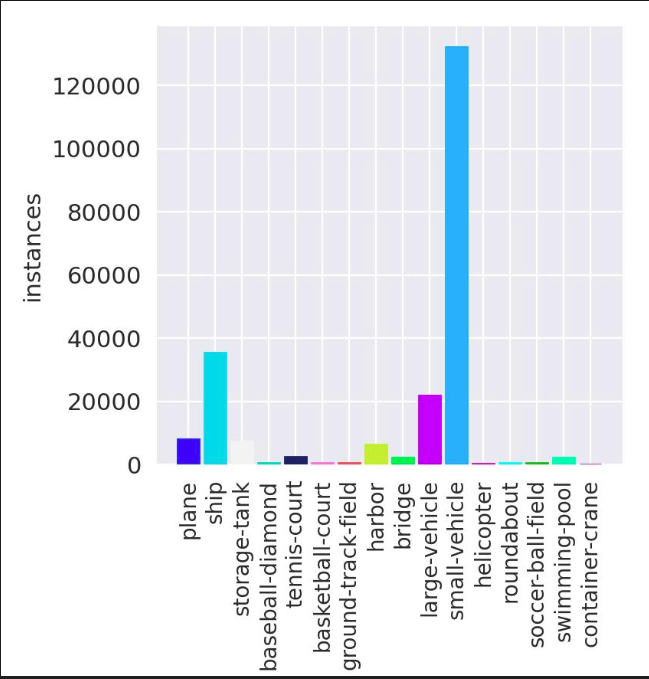


### конвертируем в jpeg  и сжимаем изображения

In [14]:
image = 'dataset_DOTA/dataset_DOTA/images/'   
labels = 'dataset_DOTA/dataset_DOTA/yolo_labels/'   
image_jpeg = 'dataset_DOTA/dataset_DOTA/images_jpeg/'   

# convert_gpg1(path_dataset, image, labels, image_jpeg)

### изменение разметки датасета DOTA  для датасета UAVOD

In [15]:
# ===============    Словарь  классов для переименования
    # class_map = {
    #     0: 1,
    #     1: 7,
    #     7: 10,
    #     9: 11,
    #     10: 8,
    #     11: 12
    # }

# =======================     Классы, которые удаляем 
# remove_classes = {2, 3, 4, 5, 6, 8, 12, 13, 14, 15}
input_dir = "/dataset_full_3/labels/val/"
# cleaned1(class_map, remove_classes, input_dir, path_dataset)

In [ ]:
def aug_3():
    # Получаем текущую рабочую папку  
    current_directory = os.getcwd()  

    path_dataset = os.path.join(current_directory, "dataset")

    dataset = 0

    # Пути к датасету
    if dataset == 0:
        image_1 = 'dataset_DOTA/set/image/train/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_DOTA/set/target/train/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/train/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/train/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 1:
        image_1 = 'dataset_DOTA/set/image/test/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_DOTA/set/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/test/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/test/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)  
    elif dataset == 2:
        image_1 = 'dataset_DOTA/set/image/test/'   
        input_images_dir = os.path.join(path_dataset, image_1)  
        labels_1 = 'dataset_DOTA/set/target/test/'  
        input_labels_dir = os.path.join(path_dataset, labels_1) 


        image_2 = 'dataset_full_1/images/val/'   
        output_images_dir = os.path.join(path_dataset, image_2)  
        labels_2 = 'dataset_full_1/labels/val/'   
        output_labels_dir = os.path.join(path_dataset, labels_2)        


    generate_crops_for_dataset(
        image_dir=input_images_dir,  
        label_dir=input_labels_dir, 
        output_img_dir=output_images_dir,  
        output_lbl_dir=output_labels_dir, 
        crop_size=1300,         # Размер вырезки
        step=150,                # Шаг для сдвигов окна
        exclude_classes=[0, 2, 3, 4,]  # Исключенные классы
    )

# aug_3()

#### Баланс классов после добавления датасета DOTA  

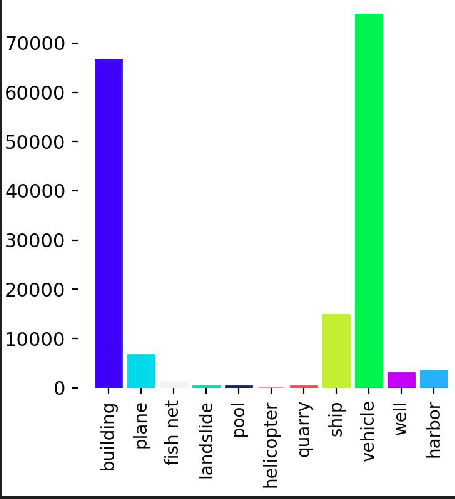